In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from rusenttokenize import ru_sent_tokenize
import pymorphy3

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, \
f1_score, log_loss
import evaluate
from scipy.special import softmax

from itertools import chain
from collections import Counter
import re

from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification,  \
Trainer, TrainingArguments

import json
import yaml

import tqdm
from tqdm import tqdm_notebook
from tqdm.auto import tqdm

from typing import Dict

import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
simplefilter("ignore", category=RuntimeWarning)


In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Описание задачи

В данной работе решалась NLP-задача определения тональности отзывов клиентов онлайн-магазина "Ozon". 

Источник отзывов - otzovik.com

Количеcтво отзывов - 14792.

Тональность определялась как позитив/негатив (метки 1/0). Отзывы, которые клиенты оценивали до 3 баллов включительно расценивались как негативные (0), 4,5 баллов - позитивные (1).

Содержание отзывов приведено в столбце reviewText, пользовательская оценка - в столбке label.
Данные предварительно разделены на обучающую и тестовую выборки в соотношении test_size=0.25.

Для токенизации текста и классификации использовалась предобученная модель-трансформер Bert, поэтому предобработка текста
осуществлялась только в объеме удаления лишних символов, чисел в тексте. Во избежании потери потери информации лемматизация/стемминг и удаление стоп-слов не производились.

In [3]:
config_path = "../config/config.yaml"
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

In [4]:
preproc = config['preprocessing']
train_params = config['train']

In [5]:
config

{'preprocessing': {'random_state': 10,
  'test_size': 0.2,
  'raw_path': '../data/raw/data_reviews.csv',
  'train_path': '../data/processed/train_data.csv',
  'test_path': '../data/processed/test_data.csv',
  'scrape_path': '../data/raw/scrape_data.csv',
  'connection_path': '../config/connection.json'},
 'train': {'max_length': 512,
  'random_state': 10,
  'learning_rate': 2e-05,
  'tokenizer_path': 'cointegrated/rubert-tiny2',
  'model_path': 'cointegrated/rubert-tiny2',
  'trainer_path': '../models/history',
  'trainer_log_path': '../models/history/history.json',
  'epochs': 4,
  'weight_decay': 0.01,
  'per_device_batch_size': 64,
  'batch_size_split': 10,
  'metrics_path': '../report/metrics/metrics.json'},
 'test': {'model_path': '../models/bert-tiny2',
  'evaluate_path': '../data/check/test_data.csv'},
 'endpoints': {'train': 'http://localhost:8000/train',
  'prediction_input': 'http://localhost:8000/predict_from_input',
  'prediction_from_file': 'http://localhost:8000/predict',

In [46]:
data = pd.read_csv(preproc['raw_path'], encoding='UTF-8')

In [47]:
data.dtypes

reviewText    object
label          int64
dtype: object

In [41]:
data.label.dtype == "int64"

AttributeError: 'DataFrame' object has no attribute 'label'

In [33]:
def check_data(data):
    """
    Проверка датасета на названия, количество столбцов и типы данных в них содержащихся
    :param data: датасет
    :return: датасет
    """
    # Если Series - проверить тип данных
    if isinstance(data, pd.Series):
        if data.dtype in [str, object]:
            data = pd.DataFrame(data, columns=['reviewText'])
            return data
        else:
            raise TypeError("Неверный тип данных в серии.")

    if isinstance(data, pd.DataFrame):
        cols = list(data.columns)

        #if cols in [["reviewText", "label"], ["reviewText", "target"]]:
        if cols in ["reviewText", "label", "target"]:
            return data
        # Если датасет содержит другие названия столбцов - проверить тип данных
        elif len(cols) == 2:
            for col in cols:
                if data[col].dtype in [str, object]:
                    data["reviewText"] = data[col]
                elif data[col].dtype in [int, 'int32', 'int64']:
                    data["label"] = data[col]
                else:
                    raise TypeError("Неверный тип данных в столбцах.")

            data = data[["reviewText", "label"]]
            return data

        elif len(cols) == 1:
            data.columns = ["reviewText"]
            if data["reviewText"].dtype in [str, object]:
                return data
            else:
                raise TypeError("Неверный формат данных.")

        else:
            raise TypeError("Неверный формат датасета.")

    else:
        raise TypeError(
            "Неподдерживаемый тип данных. Поддерживаются только pd.DataFrame и pd.Series."
        )

In [38]:
data.reviewText.dtype in ["str"]

False

In [27]:
data =  [
    "Раньше часто делали покупки в этом магазине. А за последние 3 месяца, к этому магазу появилось негативное отношение. При покупке из за рубежа, получаем товар на почте. Так вот, при вскрытии посылки дома обнаружили, что товар с браком. Покупали квадрокоптер, у него оказался напрочь отломан пропеллер. Пишу сообщение в поддержку. отвечает как всегда робот. После получаса общения с ним появился оператор. Он предлагает отправить мне за свои деньги бракованный товар обратно в Китай. С какой стати вы посредник, вам и отвечать-ответ однозначен отправьте обратно сами. Вот так. До этого случая покупали измельчитель, тоже пришел с браком, так\n\n\n\nс первого раза в возврате отказали, недели 2 им писали и фотки отправляли, доказывали свою правоту. Квадрокоптер выкинули в мусорку, деньги на ветер +потраченные нервы. Подумайте прежде чем покупать что то из бытовой техники, замучаетесь потом доказывать, что виноват продавец. Зарекаюсь в озоне покупать, что то сложнее мыла или полотенец .",
    "Заказала перед новым годом доставку курьером подарков для своего родственника, одинокого пожилого дяди в другой город. Сначала откладывалась доставка, но это было не критично. \n\n\n\nПодарки приятно и после праздников получать. 9 января пришло уведомление, что все товары доставлены получателю. И я позвонила и оказалось, что ему ничего не приносили. Я обратилась в компанию озон за помощью, связаться по телефону с ними не возможно, только чат, а там шаблонные отписки. Сначала писали сроки решения вопроса, но когда 2 раза сроки вышли, решили уже и их не указывать. Вот так теперь зарабатывают в компании озон. Деньги забрали, товар не доставили, главное в программе написать, что получено. И главное отписками в чате можно бесконечно долго заниматься, там уже шаблоны набиты. И доказать что либо будет сложно. Я думаю многие и не будут связываться и тратить ещё свои нервы и время. Я не рекомендую пользоваться курьерской доставкой в компании озон. Не рискуете!",
    "Непроверенные продавцы. Продавцы представленные на OZONе часто не занимаются этой деятельностью. Возможно это жулики под именем магазина. После покупки товара через 3 часа позвонили якобы из службы поддержки и выведав пароль, вошли в мой аккаунт в банке Озона. Отменили заказ, перевели деньги снова на карту и сняли деньги. Деньги перевелись за считанные минуты, хоть на сайте и обещают за 2 - 3 дня. Подтверждение снятия денег с карты в виде СМС не пришло. Остался и без товара, и без крупной суммы денег. Сработано чётко, даже телефоны по которым меня разводили, как-то изменили.Проверяйте профиль магазинов и отзывы о них в интернете. Озоновской картой пользоваться опасно, хоть и заманивают скидкой в 30 процентов и доставкой за три дня.Будьте бдительными, а не как я.",
    "Курьер ОЗОН третий день возит в кузове грузовика телевизор по моему заказу №41021361-0020 а мне не доставляет. Что останется от такой перевозки товара одному богу известно, вероятно курьер привезет в хлам убитый товар. Операторы ОЗОНА на мои просьбы связать меня с курьером отказывают. Высший пилотаж \"обслуживания\"",
    "Должны были доставить два заказа 26.11.2022 с 10:00 до 22:00. В 21:09 я позвонила курьеру узнать когда он приедет, на что он сказал, что у него 144 заказа, он не успел их развести и мой заказ не доставит. После чего мой заказ без моего ведома перенесли на 28.11.2022 опять с 10:00 до 22:00. Курьер все тот же самый. В 15 часов приходит сообщение о переносе доставки моих заказов на 29.11.2022. Пишу курьеру в ватс апп, а из его ответов следует, что он смену не закрыл, 27.11.2022 не был в моем районе, 28.11.2022 у него вообще выходной. Самое забавное, что сегодня видела машину ОЗОН в нашем поселке, ехал разгружаться на ПВЗ, в вот Курьер уже три дня доехать не может. Не рекомендую выбирать способ доставки курьером, лучше в ПВЗ",
    "Любые интернет площадки дают приветственные бонусы для привлечения новых покупателей. Озон не исключение. И до настоящего момента всё еще действует акция, по которой на первые заказы дают 300 рублей. Промокод я нашла на официальном сайте Ozon. Забила в гугл-поисковике: \"озон промокод на 1 заказ\", скопировала. Затем скачала мобильное приложение, зарегистрировала новый аккаунт и применила промокод.\n\n\n\n300 бонусов мне зачислились в течение 15 минут. Затем я оформила заказ. Но оплатить этими бонусами можно только 25% стоимости покупки. 1 бонус равен 1 рублю. Остаток баллов можно использовать на последующие покупки.Учтите, что неиспользованные баллы по этой акции сгорают через 5 дней. Я об этом не знала и на 6-ой день, когда собралась делать очередной заказ мои остаточные бонусы сгорели. Написала в тех. поддержку вопрос, что случилось. Объяснила, что читала правила по бонусам и там было написано, что они действительны год. Но оказалось, что для приветственных бонусов срок составляет всего 5 дней. Всё-же без лишних разговоров поддержка встала на мою сторону и все бонусы мне вернули.Честно скажу, что в последующем я воспользовалась акцией для новичков не один раз, заставляя регистрироваться мужа и родителей. Но затем они сами втягивались в покупки он-лайн и теперь тоже часто что-то заказывают.По-началу я оплачивала покупки своей обычной картой Visa, но потом выяснила, что можно завести OZON Card и по ней получать бонусы за покупки, а потом ими же расплачиваться. Зарегистрировала эту карту. Перевела нужную сумму на неё, оплатила свою покупку 3500 рублей и получила по акции 500 бонусов. Это 500 рублей, которые можно использовать для оплаты 100% стоимости покупки.Сколько бонусов вы получите при оплате картой OZON написано рядом с ценой на товар в описании. Не всегда дают так много, бывает 1%, 10%, но бывает и 50%. Правда цены, возможно, завышенные, сказать не могу, не проверяла.Затем я выяснила, что пополнять карту на сумму меньше 3 000 без комиссии можно лишь один раз. В последующем придётся платить комиссию. И для недорогих покупок (до 3 000 руб.) это делать невыгодно. И маленькие покупки снова оплачиваю своей обычной картой Visa.",
    "У меня была нормальная доставка курьера на дом от Озон. Привезли утром в заявленный день, занесли, поставили аккуратно. Позвонили заранее перед доставкой, около получаса (точно уже не помню), предупредили, что скоро будут. Раковина тяжёлая, из искусственного камня, ее из пункта выдачи не понесешь. Прибыла целая. Я очень довольна была. Особенно порадовала бесплатная доставка. Там на определенную сумму покупаешь и тогда не надо платить. От десяти тысяч в основном. Раковина стоила около двенадцати тысяч рублей. Начала на этом маркетплэйсе приобретать товары и радуюсь удобству. А тут наткнулась на эту тему с обсуждениями доставки, и удивилась настолько плохим отзывам. Решила даже здесь зарегистрироваться, чтобы свой оставить, поскольку мне нравится сервис Озона. У них, конечно бывают накладки, задержки доставки, но они звонят, если откладывают и можно договориться на другой день, если четко описать свой график оператору.\n\n\n\n",
    "Доставляют как попало, при покупке озон премиум, бесплатные доставки курьером просто игнорируют, делают отмену без объяснения причин, товар часто повреждённый.",
    "Уже вторую неделю не могут доставить товар. На выходных они едут не в мою сторону, а в будни у меня рабочие дни и я вне дома. Складывается ощущение, что это не я заплатил за доставку и выбираю время, а они заплатили. Очень, очень плохо. Ещё для тех кто не знал, если коробка весит 25 кг она входит в доставку только до подъезда, а дальше платно",
    "Поддержки нет вообще!!! При обращении постоянно меняюся операторы, которые не читают вопрос и не вникаю в проблему. Отвечают шаблонно. Куда и к кому обращаться за помощью в итоге не понятно."
  ]

In [34]:
df = pd.Series(data, name='reviewText')

In [44]:
df[8]

'Уже вторую неделю не могут доставить товар. На выходных они едут не в мою сторону, а в будни у меня рабочие дни и я вне дома. Складывается ощущение, что это не я заплатил за доставку и выбираю время, а они заплатили. Очень, очень плохо. Ещё для тех кто не знал, если коробка весит 25 кг она входит в доставку только до подъезда, а дальше платно'

In [36]:
df.to_csv('scsc.csv', index=False)

In [13]:
data.to_csv(preproc['raw_path'], encoding='UTF-8', index=False)

In [27]:
device = torch.device

In [31]:
tram = Trainer()

RuntimeError: `Trainer` requires either a `model` or `model_init` argument

In [26]:
data.rename(columns={list(data)[1]: 'labels'})

,reviewText,labels
0,Впервые я взяла рассрочку(никогда ничего не бр...,1
1,"Только что увидела дешевый флэш накопитель, оп...",3
2,С данным интернет-магазином я познакомился год...,5
3,"Наша жизнь не стоит на месте. Время идет, и вс...",4
4,Интернет-магазин Ozon.ru .Этот интернет магази...,5
...,...,...
14801,"Везут товар хрен знает сколько, только завтрак...",1
14802,Заказывал подушку с доставкой на след. день в ...,1
14803,Неделю назад я совершила покупку на сайте мага...,1
14804,Уже в отчаянии адекватно и правильно решить пр...,1


## Preprocessing

In [6]:
def text_preprocess(s: str) -> str:
    """
    Первоначальная обработка текста, перевод букв нижний регистр,
    удаление чисел, символов переноса строки
    """
    preprocessed_text = []
    # удаление пробелов в начале и в конце строки
    s = s.strip()
    # приведение букв в нижный регистр
    s = s.lower()
    # отделение пробелами символов ".", ",", "!", "?"
    s = re.sub(r"([.,!?])", r" \1 ", s)
    # заменить на пробелы все символы, кроме а-я, А-Я, ".", ",", "!", "?"
    s = re.sub(r"[^а-яА-Я.,!?]+", " ", s)
    # убрать дублирующие пробелы
    s = re.sub(r"\s{2,}", " ", s)
    # убрать пробелы в начале и в конце строки
    s = s.strip()
    
    return s

In [7]:
data['reviewText'] = data.reviewText.transform(lambda x: text_preprocess(x))

In [8]:
data['target'] = data.label.apply(lambda x: 1 if x > 3 else 0)
data = data.drop('label', axis=1)
data.drop_duplicates().reset_index(drop=True)

,reviewText,target
0,впервые я взяла рассрочку никогда ничего не бр...,0
1,"только что увидела дешевый флэш накопитель , о...",0
2,с данным интернет магазином я познакомился год...,1
3,"наша жизнь не стоит на месте . время идет , и ...",1
4,интернет магазин . . этот интернет магазин зна...,1
...,...,...
14787,"везут товар хрен знает сколько , только завтра...",0
14788,заказывал подушку с доставкой на след . день в...,0
14789,неделю назад я совершила покупку на сайте мага...,0
14790,уже в отчаянии адекватно и правильно решить пр...,0


In [9]:
def split_data(data: pd.DataFrame, 
               test_size=0.25, 
               random_state=preproc['random_state']):
    
    train_data, test_data = train_test_split(data,
                                             stratify=data.target,
                                             test_size=test_size,
                                             random_state=random_state)
    
    return train_data.drop_duplicates().reset_index(drop=True), \
            test_data.drop_duplicates().reset_index(drop=True)
    

def get_dataset(path: str):
    
    data = pd.read_csv(path)
    cols_to_drop = data.columns[data.columns.str.startswith('Unnamed')]
    
    data.drop(cols_to_drop, axis=1, inplace=True)
    data = data.drop_duplicates().reset_index(drop=True)
    
    return data

In [10]:
train_data, test_data = split_data(data)

In [11]:
train_data = get_dataset(preproc['train_path'])
train_data

,reviewText,target
0,. . я осуществила заказ товара на сайте . . то...,0
1,на мой взгляд самый безобразный из интернет ма...,0
2,пришли по заказу на озон кроссовки аж из китая...,0
3,интернет магазином пользовалась уже несколько ...,0
4,"заказ не приш л вовремя , написал в группу под...",0
...,...,...
11831,"очень богатый выбор , активный персонал , поку...",1
11832,"буду немногословен , знаю , как вам будет инте...",0
11833,"добрый вечер , уважаемые дамы и господа ! по к...",0
11834,"все конечно удобно , продвинуто , но есть мале...",1


In [39]:
data = pd.read_csv(preproc['train_path'],
                   names=['reviewText', 'label'],
                   encoding='windows_1251')

## EDA

In [13]:
def plot_text(ax: plt.Axes):
    """
    Выводит процентные значения на столбчатой диаграмме.
    
    Параметры:
        ax (plt.Axes): Объект Axes, на котором отображается 
        столбчатая диаграмма.
    """
    # Перебираем каждый столбец на диаграмме
    for p in ax.patches:
        # Вычисляем процентное значение высоты столбца
        percentage = '{:.1f}%'.format(p.get_height())
        # Аннотируем столбец с процентным значением
        ax.annotate(
            percentage,  # Текст аннотации
            # Координаты аннотации (по центру столбца)
            (p.get_x() + p.get_width() / 2., p.get_height()),
            # Выравнивание текста
            ha='center',
            va='center',
            # Смещение текста относительно координаты
            xytext=(0, 10),
            # Использование смещения в "точках" (points)
            textcoords='offset points',
            fontsize=10
        )

        
def plot_bars(data: pd.DataFrame, target: str):
    """
    Выводит столбчатую диаграмму для данных DataFrame.
    
    Параметры:
        data: DataFrame с данными для построения столбчатой диаграммы.
    """
    # Вычисляем процентное распределение меток
    norm_target = (data[target]
                  .value_counts(normalize=True)
                  .mul(100)
                  .rename('percent')
                  .reset_index())
          
   
    plt.figure(figsize=(9, 6))
    # Строим столбчатую диаграмму
    ax = sns.barplot(x=target, 
                     y='percent', 
                     data=norm_target, 
                     palette='flare')

    # Добавляем процентные значения к столбцам
    plot_text(ax)
    
        
    # Устанавливаем заголовок графика
    ax.set_title('Оценки пользователей', fontsize=14)
    # Устанавливаем подпись оси x
    ax.set_xlabel('Оценки пользователей', fontsize=12)
    # Устанавливаем подпись оси y
    ax.set_ylabel('Доля в процентах', fontsize=12)

    # Отображаем график
    plt.show()        

    

def generate_wordcloud(text: str):
    """
    Генерирует облако слов на основе входного текста.
    
    Параметры:
        text (str): Текст для создания облака слов.
    """
    
    wordCloud = WordCloud(width = 800, 
                          height = 800, 
                          random_state=preproc['random_state'], 
                          background_color='black', 
                          colormap='Set2').generate(text)

    # Создаем фигуру для облака слов
    plt.figure(figsize=(10, 5))
    # Отображаем облако слов
    plt.imshow(wordCloud)
    # Убираем метки по осям x и y
    plt.xticks([])
    plt.yticks([])
    # Показываем облако слов
    plt.show()

In [14]:
train_data.describe(include=['object'])

,reviewText
count,11836
unique,11836
top,. . я осуществила заказ товара на сайте . . то...
freq,1


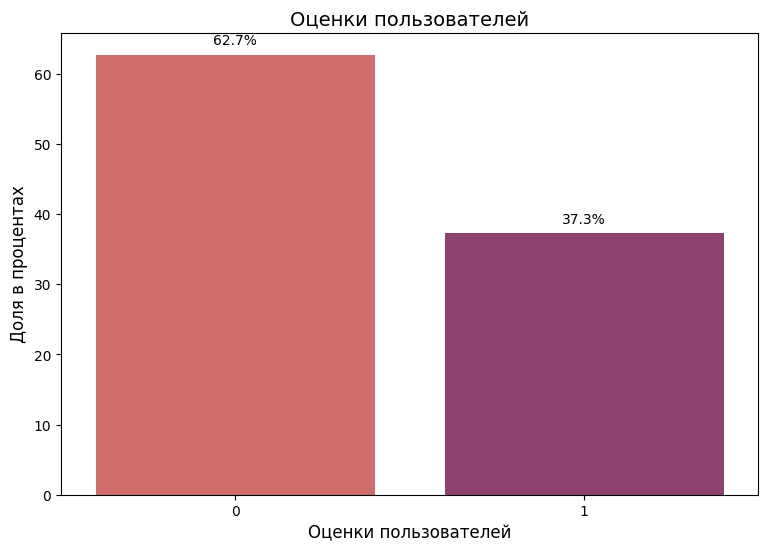

In [15]:
plot_bars(train_data, 'target')

В датасете преобладают негативные отзывы, что в определенной степени говорит о репрезентативности данных, всего на сайте отзовик представлено 23к отзывов со средней оценкой 2.9

In [51]:
def plot_histplots(data: pd.DataFrame):

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    words_count = data['reviewText'].apply(
        lambda x: len(x.split()))

    sent_count = data['reviewText'].apply(
        lambda x: len(ru_sent_tokenize(x)))

    for i, col in enumerate([words_count, sent_count]):
        median = col.median()

        sns.histplot(col,
                     ax=axes[i]).set_title(f"Количество {['слов', 'предложений'][i]} в отзыве")
        
        axes[i].set(xlabel=f"Количество {['слов', 'предложений'][i]}",
                    ylabel=f'Количество отзывов')
        axes[i].axvline(median,
                        linestyle='--',
                        color='orange',
                        label='Медиана')
        axes[i].legend()

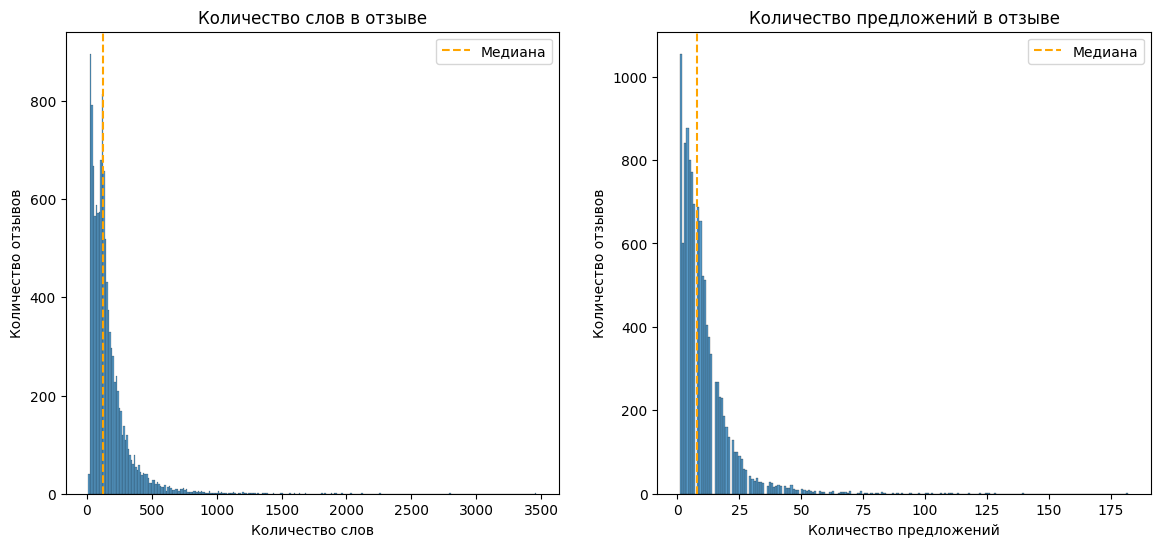

In [52]:
plot_histplots(train_data)

In [12]:
def get_data_for_eda(data:pd.DataFrame) -> pd.DataFrame:
    data['Words_count'] = data.reviewText.apply(
        lambda x: len(x.split()))
    data['Sentences_count'] =  data.reviewText.apply(
        lambda x: len(ru_sent_tokenize(x)))
    data['Review_length'] = data.reviewText.str.len()
    data['Mean_word_length'] = data.reviewText.apply(
        lambda x: np.mean([len(t) for t in x.split()]))
    data['Mean_sentence_length'] = data.reviewText.apply(
                    lambda rev: np.mean([len(sent) for sent in ru_sent_tokenize(rev)]))
    return data

In [13]:
data = get_data_for_eda(train_data)

In [44]:
def plot_boxplot(data, col_name: str, hue_name: str):
    fig = plt.figure(figsize=(6, 5))
    ax = sns.boxplot(
        data=data,
        y=col_name,
        hue=hue_name,
        palette='magma'
    )
    
def plot_kdeplot(data, col_name, hue_name):
    fig = plt.figure(figsize=(6, 5))
    ax = sns.kdeplot({'target 0': data[data[hue_name] == 0][col_name],
                       'target 1': data[data[hue_name] == 1][col_name]},
                       common_norm=False,
                       palette='viridis',
                       shade=True)
    ax.set_xlabel(col_name)
    

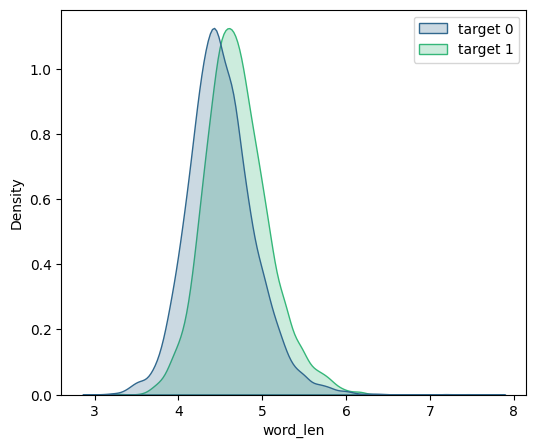

In [45]:
plot_kdeplot(data, 'word_len', 'target')

In [13]:
train_data['words_count'] = train_data['reviewText'].apply(
    lambda x: len(x.split()))

train_data['sents_count'] = train_data['reviewText'].apply(
    lambda x: len(ru_sent_tokenize(x)))

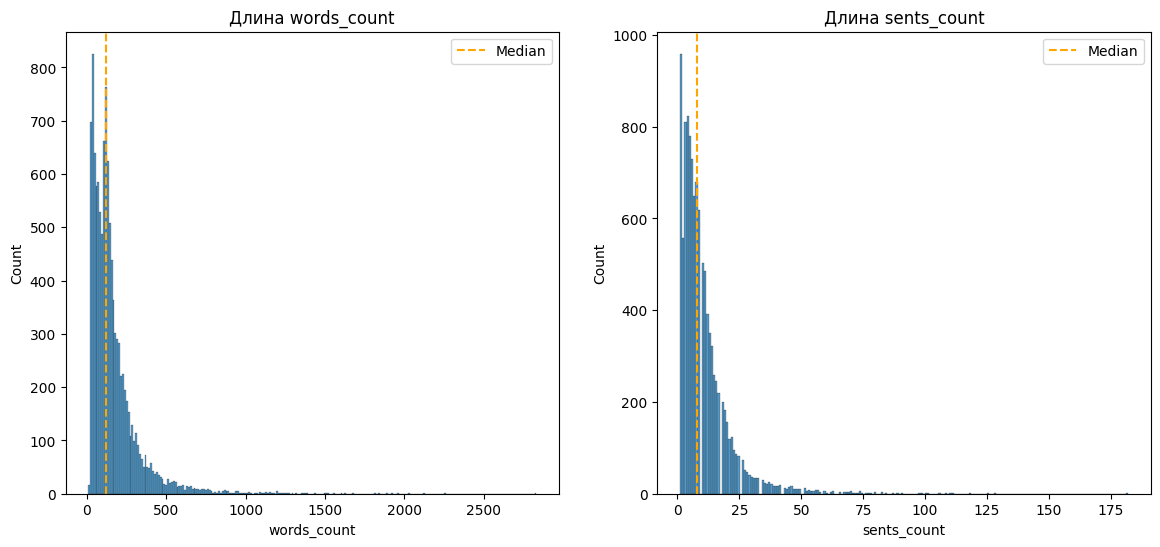

In [14]:
lst = ['words_count', 'sents_count']

# Построение гистограмм количества слов и предложений 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, col in enumerate(lst):
    median = train_data[col].median()
    
    sns.histplot(train_data[col],
                     ax=axes[i]).set(title=f'Длина {col}')
    
    axes[i].axvline(median, 
                    linestyle='--', 
                    color='orange', 
                    label='Median')
    axes[i].legend()

In [ ]:
# def plot_kdeplots(data):
#     fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
#     words_count = data['reviewText'].apply(
#         lambda x: len(x.split()))

#     sent_count = data['reviewText'].apply(
#         lambda x: len(ru_sent_tokenize(x)))
    
# for i, col in enumerate([words_count, sent_count]):
    
#     sns.kdeplot({'target 0': train_data[train_data.target == 0][col],
#                  'target 1': train_data[train_data.target == 1][col]},
#                   common_norm=False,
#                   palette='rocket',
#                   shade=True,
#                   ax=axes[i]).set_title('Density '+ col)

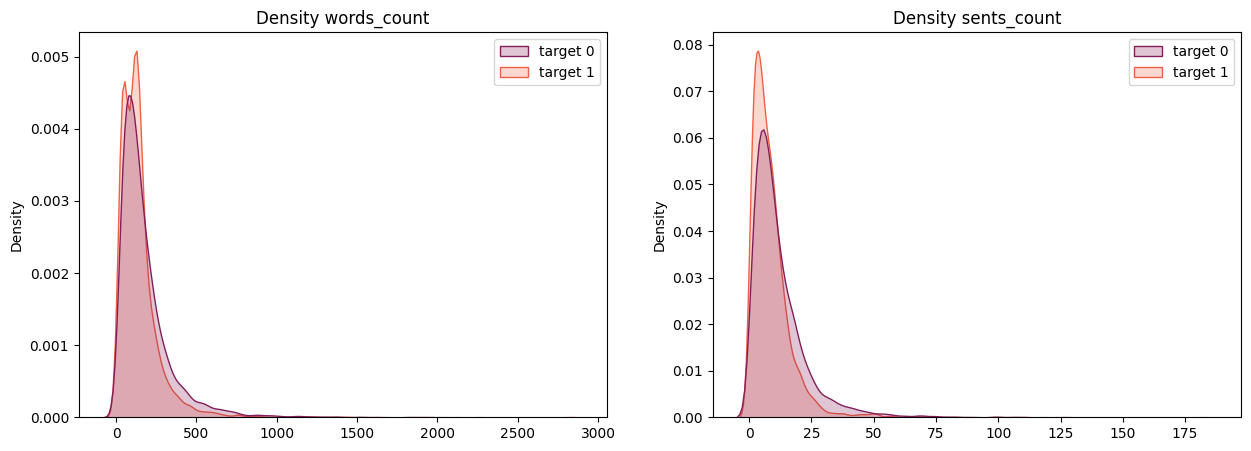

In [15]:
# Плотности распределения количества слов и предложений
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

for i, col in enumerate(lst):
    sns.kdeplot({'target 0': train_data[train_data.target == 0][col],
                 'target 1': train_data[train_data.target == 1][col]},
                  common_norm=False,
                  palette='rocket',
                  shade=True,
                  ax=axes[i]).set_title('Density '+ col)

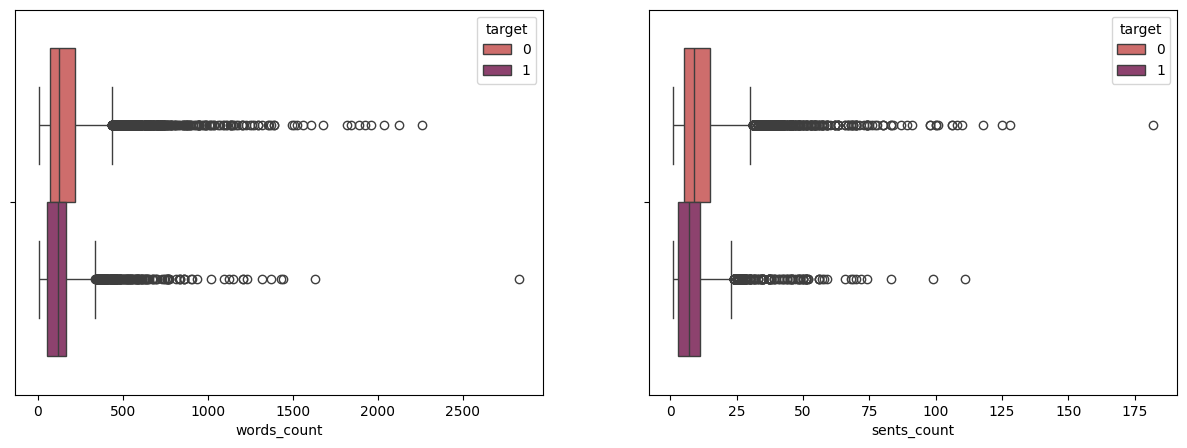

In [16]:
# Построение боксплотов
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

for i, col in enumerate(lst):
    sns.boxplot(data=train_data, 
                x=col, 
                hue='target', 
                ax=axes[i], 
                palette='flare')

In [17]:
train_data['length'] = train_data.reviewText.str.len()

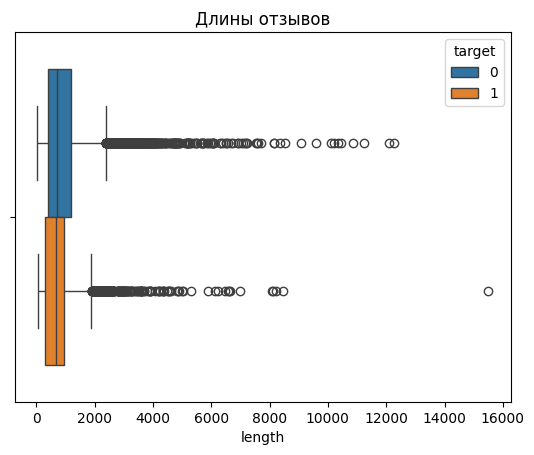

In [18]:
sns.boxplot(data=train_data, 
            x='length', 
            hue='target')

plt.title('Длины отзывов')
plt.show()

In [19]:
train_data['word_len'] = train_data.reviewText.apply(
                    lambda x: np.mean([len(t) for t in x.split()]))

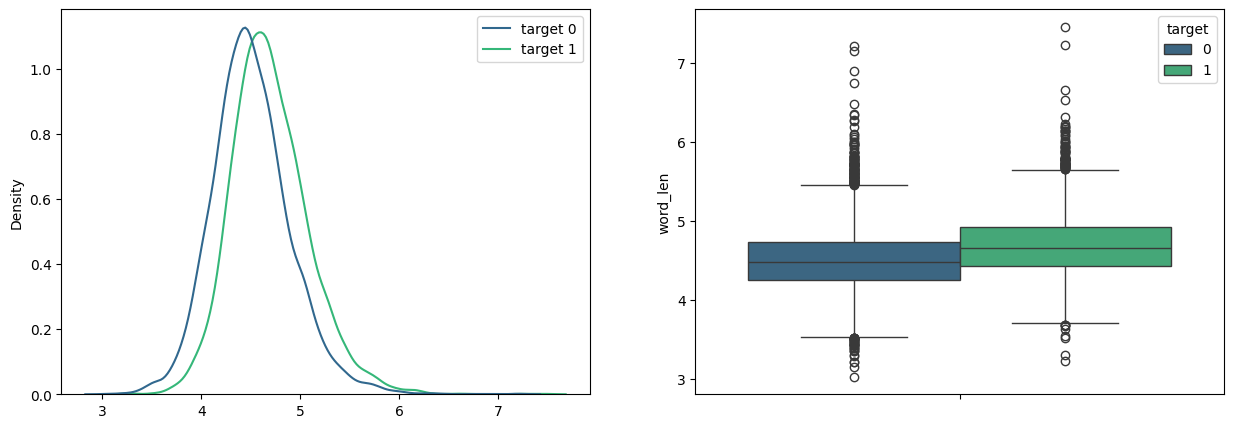

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

sns.kdeplot({'target 0': train_data[train_data.target == 0].word_len,
             'target 1': train_data[train_data.target == 1].word_len},
              common_norm=False,
              palette='viridis',
              ax=axes[0])

sns.boxplot(data=train_data, 
            y='word_len', 
            hue='target', 
            ax=axes[1], 
            palette='viridis')
plt.show()

In [21]:
train_data['sent_len'] = train_data.reviewText.apply(
                    lambda rev: np.mean([len(sent) for sent in ru_sent_tokenize(rev)]))

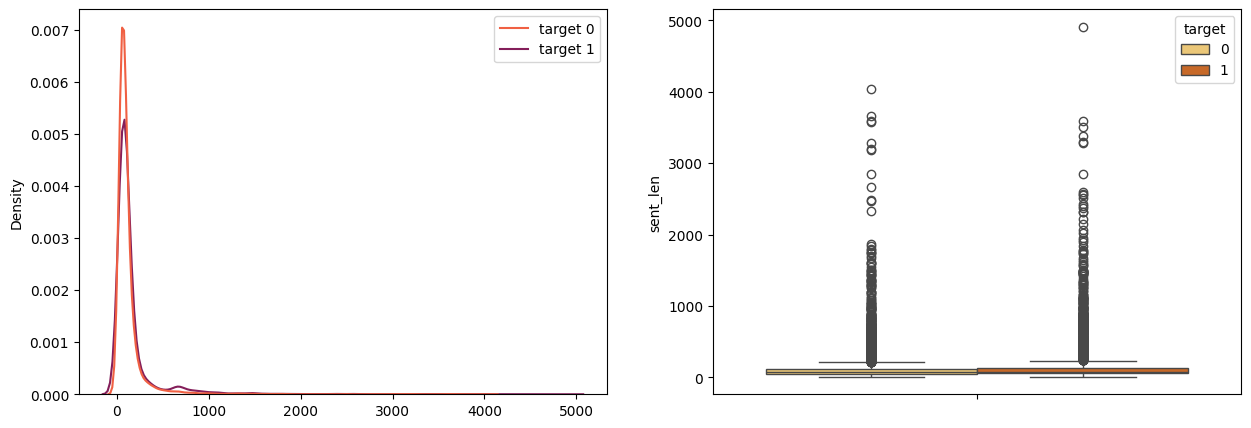

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

sns.kdeplot({'target 0': train_data[train_data.target == 0].sent_len,
             'target 1': train_data[train_data.target == 1].sent_len},
              common_norm=False,
              palette='rocket_r',
              ax=axes[0])

sns.boxplot(data=train_data, 
            y='sent_len', 
            hue='target', 
            ax=axes[1], 
            palette='YlOrBr')
plt.show()

In [23]:
len(ru_sent_tokenize(train_data.reviewText[0])[0])

85

In [24]:
train_data.describe()

,target,words_count,sents_count,length,word_len,sent_len
count,11187.000000,11187.000000,11187.000000,11187.000000,11187.000000,11187.000000
mean,0.372665,164.007151,10.668454,905.185751,4.579439,137.936127
std,0.483536,163.553426,10.626804,896.535609,0.404891,236.663397
min,0.000000,7.000000,1.000000,41.000000,3.030303,9.144578
25%,0.000000,67.000000,4.000000,374.000000,4.314390,55.539394
50%,0.000000,122.000000,8.000000,680.000000,4.548387,78.750000
75%,1.000000,200.000000,14.000000,1095.500000,4.814604,123.700000
max,1.000000,2831.000000,182.000000,15502.000000,7.461538,4912.000000


In [52]:
punctuation_marks = ['!', ',', '(', ')', ':', '-', '?', '.', '..', \
                     '...', '«', '»', ';', '–', '--']

stop_words = stopwords.words("russian")

# Корпус всех отзывов (без учета стоп-слов)
corpus = [[word for word in rev.split() if word not in punctuation_marks and word not in  \
          stop_words] for rev in train_data.reviewText.tolist()]

# Словарь корпуса
counter = Counter(chain(*corpus))

# Отсортированные по убыванию пары словаря (слово - количество употреблений в корпусе) 
most = counter.most_common()

words = []
count = []

# 30 самых часто встречаемых слов в словаре
for term in most[:30]:
    words.append(term[0])
    count.append(term[1])

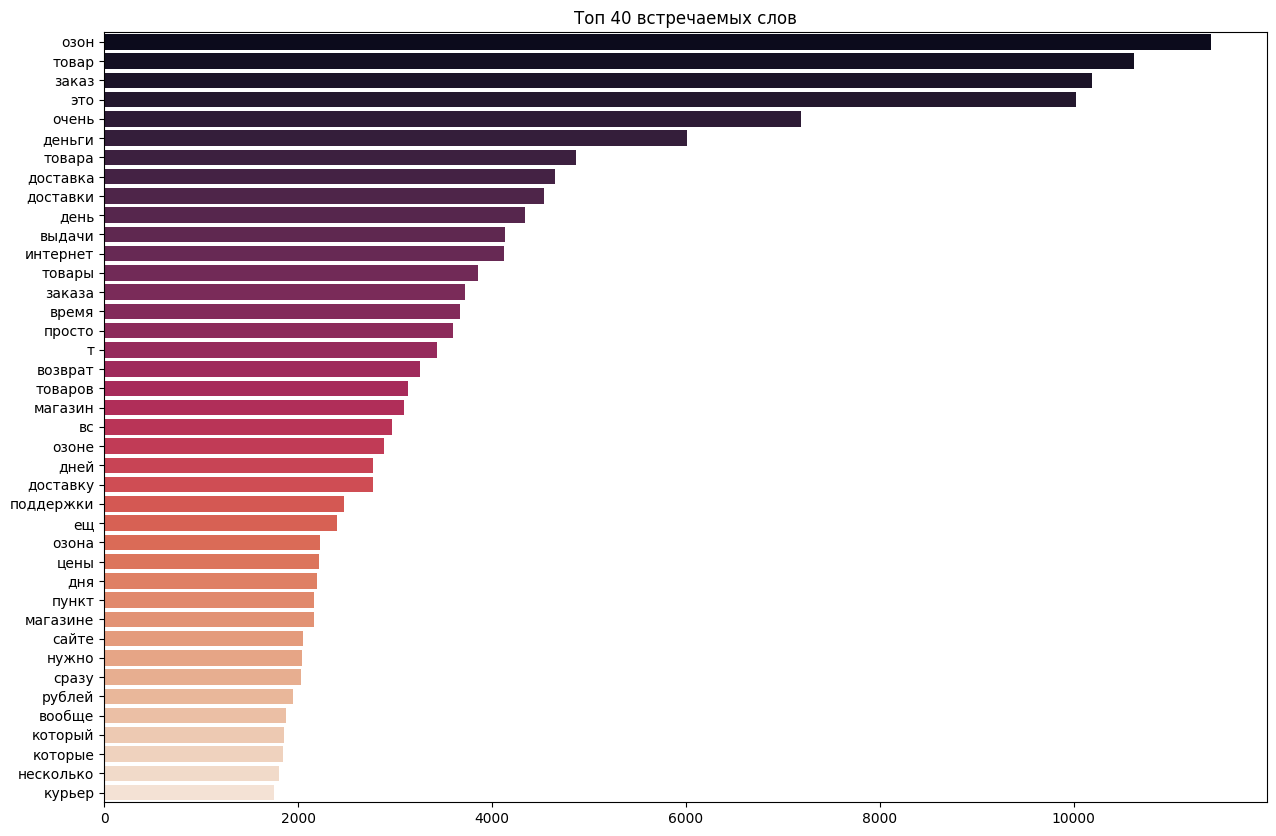

In [51]:
plt.figure(figsize=(15, 10))
sns.barplot(y=words, 
            x=count, 
            orient='h', 
            palette='rocket')

plt.title('Топ 40 встречаемых слов')
plt.show()

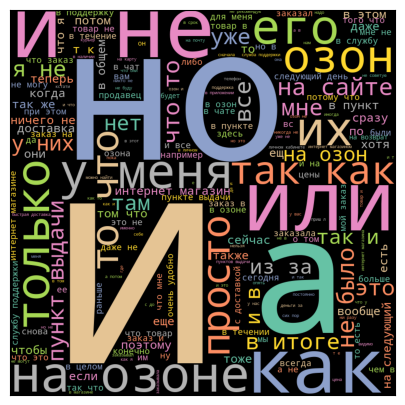

In [30]:
all_tokens = ' '.join(token_string for token_string in train_data.reviewText)
generate_wordcloud(all_tokens)

## Training

In [53]:
train_dataframe = get_dataset(preproc['train_path'])

In [54]:
train_dataframe

,reviewText,target
0,. . я осуществила заказ товара на сайте . . то...,0
1,на мой взгляд самый безобразный из интернет ма...,0
2,пришли по заказу на озон кроссовки аж из китая...,0
3,интернет магазином пользовалась уже несколько ...,0
4,"заказ не приш л вовремя , написал в группу под...",0
...,...,...
11831,"очень богатый выбор , активный персонал , поку...",1
11832,"буду немногословен , знаю , как вам будет инте...",0
11833,"добрый вечер , уважаемые дамы и господа ! по к...",0
11834,"все конечно удобно , продвинуто , но есть мале...",1


In [55]:
train_dataframe, val_dataframe = split_data(train_dataframe, test_size=0.15)

In [56]:
train_params = config['train']

In [57]:
tokenizer = BertTokenizer.from_pretrained(train_params['tokenizer_path'])

In [58]:
class PrepareData:
    
    def __init__(self, texts, tokenizer, batch_size_split=10, 
                 max_length=train_params['max_length']):
        
        self.texts = texts
        self.tokenizer = tokenizer
        self.batch_size_split = batch_size_split
        self.max_length = max_length
        
    def pre_tokenizer(self, text):
        return self.tokenizer(text,
                              add_special_tokens=True, 
                              max_length=self.max_length,
                              pad_to_max_length=True,
                              truncation=True,
                              return_attention_mask=True,
                              return_tensors='pt')
    
        
    def transform(self):
        
        N = len(self.texts)
        size_split = N // self.batch_size_split

        train_encodings = self.pre_tokenizer(self.texts[:size_split])
        input_ids = train_encodings['input_ids']
        attention_mask = train_encodings['attention_mask']
        token_type_ids = train_encodings['token_type_ids']

        for pos in tqdm(range(size_split, N, size_split)):
            train_encodings_2 = self.pre_tokenizer(self.texts[pos:pos +
                                                              size_split])
            input_ids = torch.cat((input_ids, train_encodings_2['input_ids']))
            attention_mask = torch.cat(
                (attention_mask, train_encodings_2['attention_mask']))
            token_type_ids = torch.cat(
                (token_type_ids, train_encodings_2['token_type_ids']))
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids
        } 

In [59]:
class CustomDataset(torch.utils.data.Dataset):
    
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [60]:
clf_train = PrepareData(train_dataframe.reviewText.tolist(), tokenizer)
train_encodings = clf_train.transform()
clf_val = PrepareData(val_dataframe.reviewText.tolist(), tokenizer)
val_encodings = clf_val.transform()

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [61]:
train_dataset = CustomDataset(train_encodings, train_dataframe.target.tolist())
val_dataset = CustomDataset(val_encodings, val_dataframe.target.tolist())

In [63]:
train_dataset.labels

[1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,


In [64]:
model = BertForSequenceClassification.from_pretrained(train_params['model_path'])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
def compute_metrics(eval_preds):
    """Расчет метрики roc-auc"""

    metric = evaluate.load("roc_auc")
    logits, labels = eval_preds
    predictions = softmax(logits)[:, 1]
    res = metric.compute(prediction_scores=predictions, 
                         references=labels)

    return {'roc_auc': res['roc_auc']}


def get_metrics(y_test: np.array, y_pred: np.array, y_proba: np.array) -> Dict:
    dict_metrics = {
        'roc_auc': round(roc_auc_score(y_test, y_proba[:, 1]), 3),
        'precision': round(precision_score(y_test, y_pred), 3),
        'recall': round(recall_score(y_test, y_pred), 3),
        'f1': round(f1_score(y_test, y_pred), 3),
        'logloss': round(log_loss(y_test, y_proba), 3)
    }

    return dict_metrics

In [66]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [67]:
for param in model.bert.parameters():
    param.requires_grad = False

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, 

In [241]:
config

{'preprocessing': {'random_state': 10,
  'test_size': 0.25,
  'raw_path': '../data/raw/data_reviews.csv',
  'train_path': '../data/processed/train_data.csv',
  'test_path': '../data/processed/test_data.csv'},
 'train': {'max_length': 512,
  'batch_size': 8,
  'random_state': 10,
  'learning_rate': 2e-05,
  'tokenizer_path': 'cointegrated/rubert-tiny2',
  'model_path': 'cointegrated/rubert-tiny2',
  'epochs': 10,
  'weight_decay': 0.01,
  'per_device_batch_size': 64,
  'batch_size_split': 10,
  'metrics_path': '../metrics/metrics.json'},
 'test': {}}

In [68]:
args = TrainingArguments("bert_tiny2",
                         evaluation_strategy="epoch",
                         save_strategy="no",
                         learning_rate=train_params['learning_rate'],
                         num_train_epochs=1,
                         weight_decay=train_params['weight_decay'],
                         push_to_hub=False,
                         per_device_train_batch_size=train_params['per_device_batch_size'])

In [69]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc
1,No log,0.684323,0.524526


TrainOutput(global_step=158, training_loss=0.6887724671182753, metrics={'train_runtime': 25.338, 'train_samples_per_second': 397.031, 'train_steps_per_second': 6.236, 'total_flos': 74184522178560.0, 'train_loss': 0.6887724671182753, 'epoch': 1.0})

In [70]:
trainer.state.log_history

[{'eval_loss': 0.6843230128288269,
  'eval_roc_auc': 0.524525809933448,
  'eval_runtime': 4.2725,
  'eval_samples_per_second': 415.681,
  'eval_steps_per_second': 51.96,
  'epoch': 1.0,
  'step': 158},
 {'train_runtime': 25.338,
  'train_samples_per_second': 397.031,
  'train_steps_per_second': 6.236,
  'total_flos': 74184522178560.0,
  'train_loss': 0.6887724671182753,
  'epoch': 1.0,
  'step': 158}]

In [71]:
import json

In [72]:
with open('trainer_log.json', 'w') as json_file:
    json.dump(trainer.state.log_history, json_file)

In [73]:
with open('trainer_log.json', 'r') as json_file:
    f = json.load(json_file)

In [74]:
f

[{'eval_loss': 0.6843230128288269,
  'eval_roc_auc': 0.524525809933448,
  'eval_runtime': 4.2725,
  'eval_samples_per_second': 415.681,
  'eval_steps_per_second': 51.96,
  'epoch': 1.0,
  'step': 158},
 {'train_runtime': 25.338,
  'train_samples_per_second': 397.031,
  'train_steps_per_second': 6.236,
  'total_flos': 74184522178560.0,
  'train_loss': 0.6887724671182753,
  'epoch': 1.0,
  'step': 158}]

In [223]:
def plotting_trainer_loss(trainer):
    auc = []
    eval_loss = []
    
    
    for step in trainer.state.log_history:
        try:
            auc.append(step["eval_roc_auc"])
            eval_loss.append(step['eval_loss'])
            
        except KeyError:
            continue
    
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    sns.lineplot(eval_loss, ax=axes[0], color='orange')
    sns.lineplot(auc, ax=axes[1])
    
    axes[0].set_title('Validation Loss')
    axes[1].set_title('ROC-AUC SCORE')
    axes[0].set(xlabel='Epochs')
    axes[1].set(xlabel='Epochs')

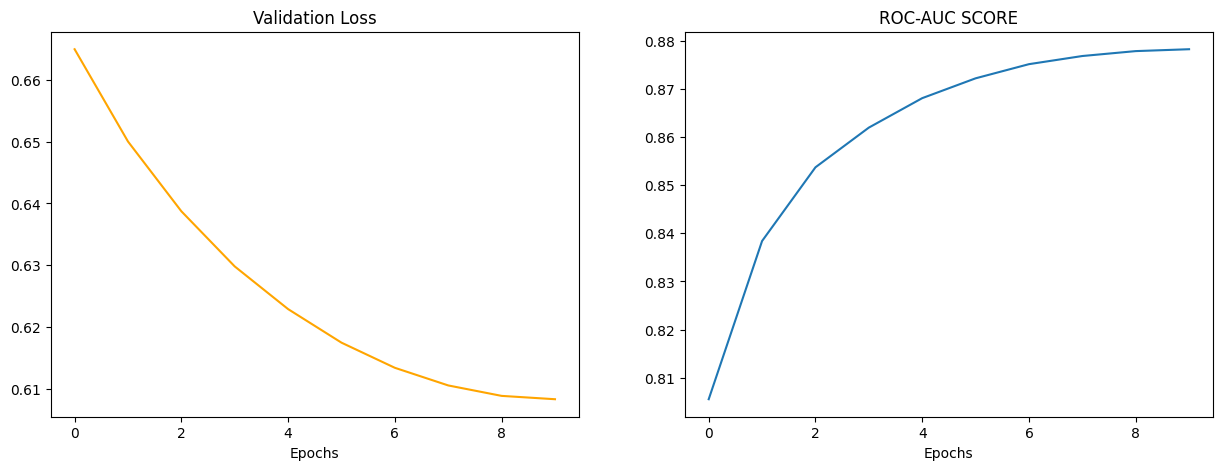

In [224]:
plotting_trainer_loss(trainer)

In [225]:
# Предсказание модели классификации Bert
y_pred = trainer.predict(train_dataset)

# Получение вероятностей
pred_proba = y_pred[0]

# Получение предсказанных меток класса
pred = pred_proba.argmax(axis=1)

In [227]:
y_train = train_dataframe.target.tolist()
metrics = get_metrics(y_train, pred, pred_proba)
metrics

In [230]:
with open (train_params['metrics_path'], 'w') as f:
    json.dump(metrics, f)

In [231]:
for param in model.bert.parameters():
    param.requires_grad = True

In [232]:
args = TrainingArguments("bert_tiny2",
                         evaluation_strategy="epoch",
                         save_strategy="no",
                         learning_rate=train_params['learning_rate'],
                         num_train_epochs=train_params['epochs'],
                         weight_decay=train_params['weight_decay'],
                         push_to_hub=False,
                         per_device_train_batch_size=train_params['per_device_train_batch_size'],
                         logging_steps=500)

In [233]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc
1,No log,0.200394,0.972575
2,No log,0.179767,0.978376
3,No log,0.164808,0.981715
4,0.239900,0.158612,0.983044
5,0.239900,0.160901,0.983861
6,0.239900,0.157472,0.984068
7,0.150000,0.157072,0.984133
8,0.150000,0.158252,0.984309
9,0.150000,0.158942,0.984330
10,0.150000,0.158891,0.984199


TrainOutput(global_step=1490, training_loss=0.17019328174975096, metrics={'train_runtime': 574.6931, 'train_samples_per_second': 165.445, 'train_steps_per_second': 2.593, 'total_flos': 701139599278080.0, 'train_loss': 0.17019328174975096, 'epoch': 10.0})

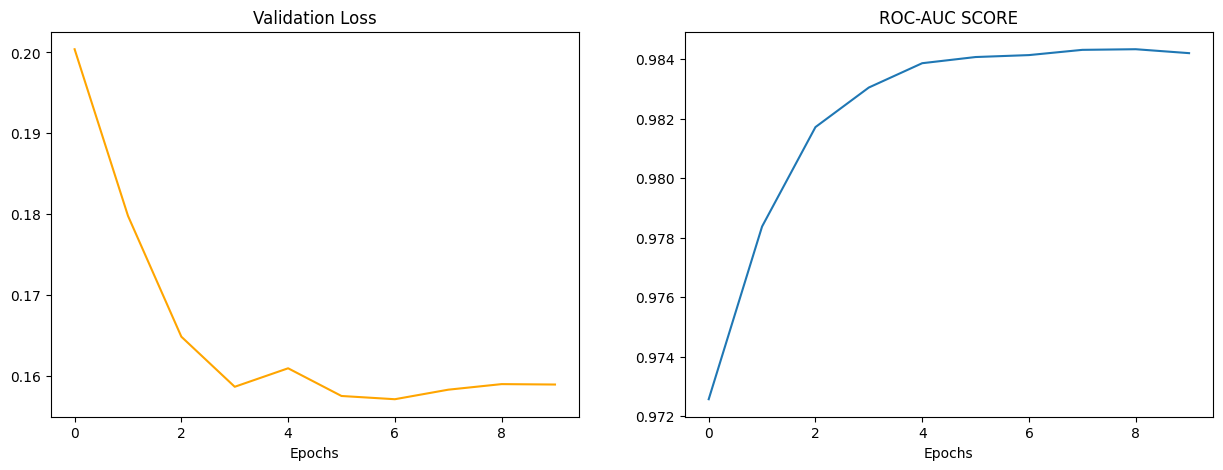

In [234]:
plotting_trainer_loss(trainer)

In [236]:
# Предсказание модели классификации Bert
y_pred = trainer.predict(train_dataset)

# Получение вероятностей
pred_proba = y_pred[0]

# Получение предсказанных меток класса
pred = pred_proba.argmax(axis=1)

In [237]:
metrics = get_metrics(y_train, pred, pred_proba)
metrics

{'roc_auc': 0.992,
 'precision': 0.968,
 'recall': 0.952,
 'f1': 0.96,
 'logloss': 0.446}

In [238]:
with open (train_params['metrics_path'], 'a') as f:
    json.dump(metrics, f)